# **Project: Text Generation Program**

**Họ và tên: Võ Phan Anh Quân**

# **Phần 1: Lý thuyết**

Transformer: Attention is all you need cùng với cơ chế Attention [Vaswani et al., 2017] đã cách mạng hoá việc xử lý các dữ liệu dạng sequence (chuỗi thời gian) như time series, text, music,... Bằng cách khai thác khả năng tính toán song song tương tự như các mô hình CNNs, đồng thời mã hóa vị trí của từng phần tử trong chuỗi, các tokens sẽ Attend (quan sát) lẫn nhau và cố gắng "hiểu" nhau trong ngữ cảnh của các tokens xung quanh thay vì phải tính toán hồi quy.

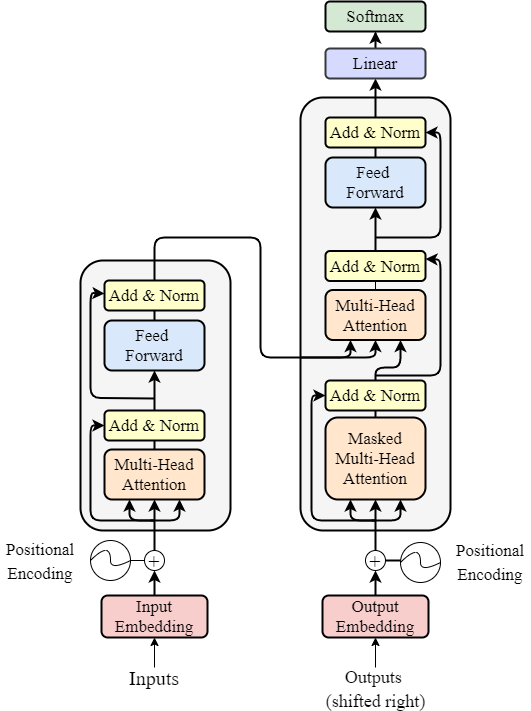

Cơ chế Attention đã khắc phục được các nhược điểm lớn của các mô hình dạng hồi quy như RNN, LSTM,... Cụ thể:
* Các mạng **CNN** có thể dễ dàng được thực hiện song song ở một tầng nhưng không có khả năng
nắm bắt các phụ thuộc chuỗi có độ dài biến thiên.
* Các mạng **RNN** có khả năng nắm bắt các thông tin cách xa nhau trong chuỗi có độ dài biến thiên, nhưng không thể thực hiện song song trong một chuỗi.
* **Trasformer** cùng cơ chế **Attention** đã kết hợp các ưu điểm của CNN và RNN, từ đó giúp cho quá trình huấn luyện nhanh hơn và kết quả đạt được cũng tốt hơn.
* **BERT: Bidirectional Encoder Representations from Transformers**. Kiến trúc của mô hình BERT là một kiến trúc đa tầng gồm nhiều lớp **Bidirectional Transformer encoder**. Đúng như tên gọi **BERT** về bản chất chính là khối **Encoder** của kiến trúc **Transformer**

## **1. Embedding Layer**

Trong biểu diễn one-hot của một ngôn ngữ, mỗi từ có một phần tử vector có độ lớn bằng kích thước của tập từ vựng. Đối với tập từ vựng 8 từ, vector biểu diễn cho mỗi từ cũng sẽ có kích thước là 8.

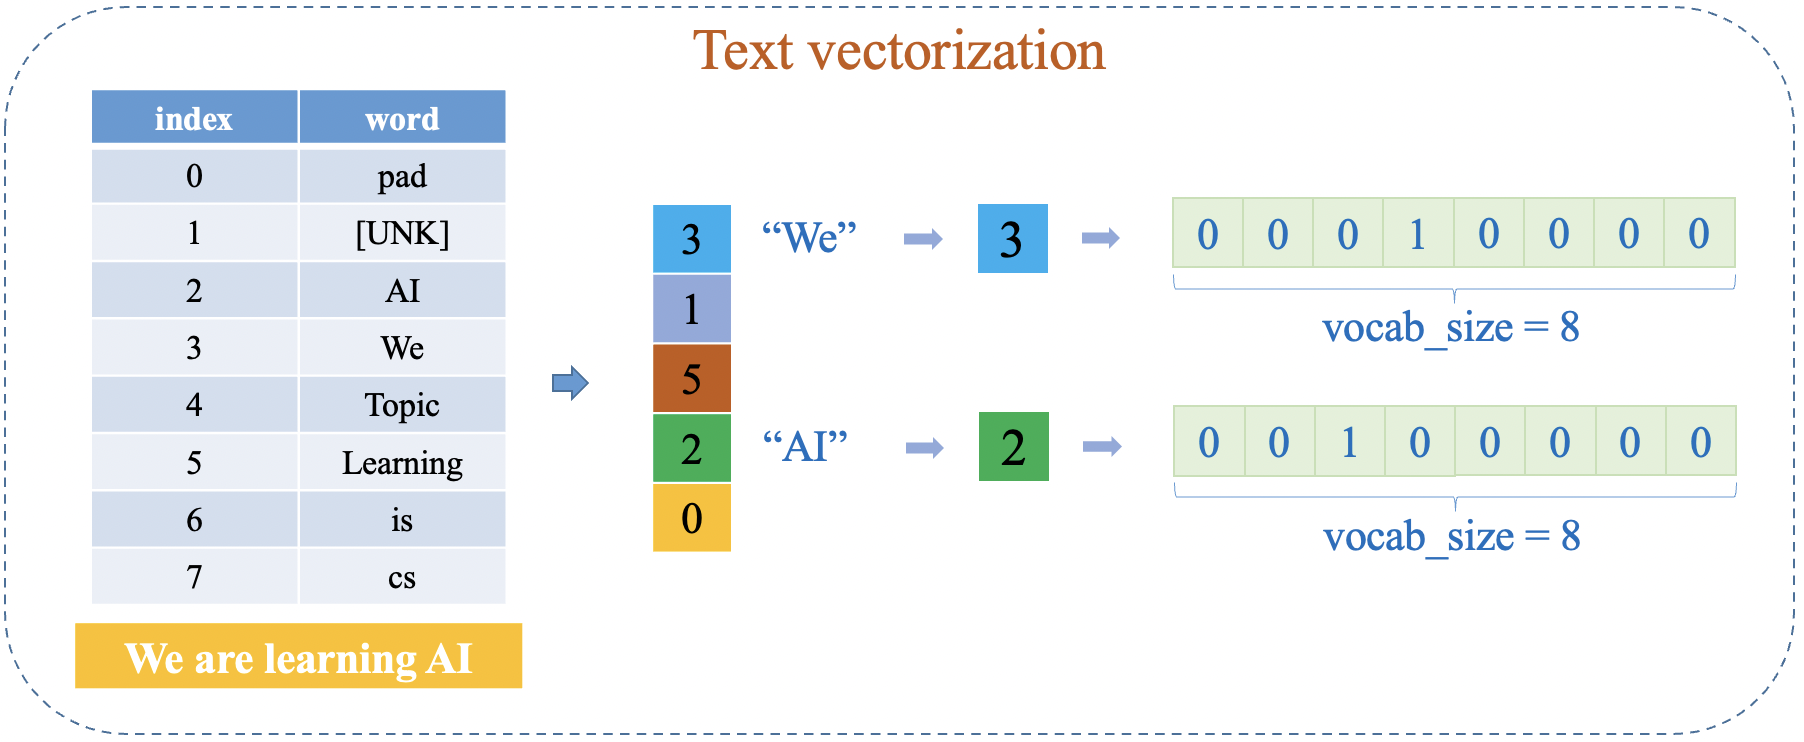

Khi tập từ vựng lớn (VD: 500k từ, vector biểu diễn cho mỗi từ cũng sẽ có kích thước là 500k. Những vector này khiến cho việc tính toán trở nên kém hiệu quả.

Trong lớp Embedding, những vector này sẽ được ánh xạ xuống một vùng không gian có số chiều thấp hơn. Điều này giúp công việc tính toán nhẹ nhàng hơn tuy nhiên số chiều được ánh xạ càng nhỏ thì thông tin bị thất thoát càng nhiều.

Thông qua phép nhân ma trận, một ma trận ánh xạ có thể chuyển tập vector one-hot ban đầu thành mọi kích thước mong muốn. Thông qua huấn luyện, mô hình có thể học cách biểu diễn ngôn ngữ một cách tốt nhất có thể (những từ có liên quan được nhóm gần với nhau)

## **2. Positional Encoding**

Sự xuất hiện của kiến trúc **Attention** giúp những mô hình tương tự với **Transformer** loại bỏ hoàn toàn cấu trúc hồi quy có trong những mô hình **RNNs**. Những token đầu vào được truyền đồng thời vào mô hình, chính vì vậy bản thân mô hình không có khái niệm về vị trí/ thứ tự giữa các token.

Để khắc phục vấn đề này, chúng ta cần truyền thêm thông tin về vị trí của các token thông qua **Positional Encoding.** Có nhiều phương pháp khác nhau để khởi tạo **Positional Encoding**, ở đây chúng ta sẽ giới thiệu hàm **Sinusoid** theo như bản gốc của bài báo **Transformer**. 

Có thể hiểu một cách đơn giản, hàm **Sinusoid** giúp xê dịch các vector embeding của các tokens một cách độc nhất. Phương trình của hàm này như sau:

$$PE_{(pos, 2i)} = sin\bigg(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\bigg)$$

$$PE_{(pos, 2i+1)} = cos\bigg(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\bigg)$$



## **3. Attention Block**

### **(a) Attention là phép nhân ma trận**

Cơ chế Attention là trái tim của toàn bộ mô hình Transformer và các biến thể của Transformer. Phương trình toán học của cơ chế này được mô tả bởi công thức sau:
$$Attention(Q,K,V) = softmax\bigg(\frac{QK^T}{\sqrt{d_k}}\bigg)V$$

Thông qua phép nhân ma trận $QK^T$ mô hình có thể chọn lọc những tokens nào cần tập trung và những tokens nào ít quan trọng hơn. Ta có ví dụ sau đây:

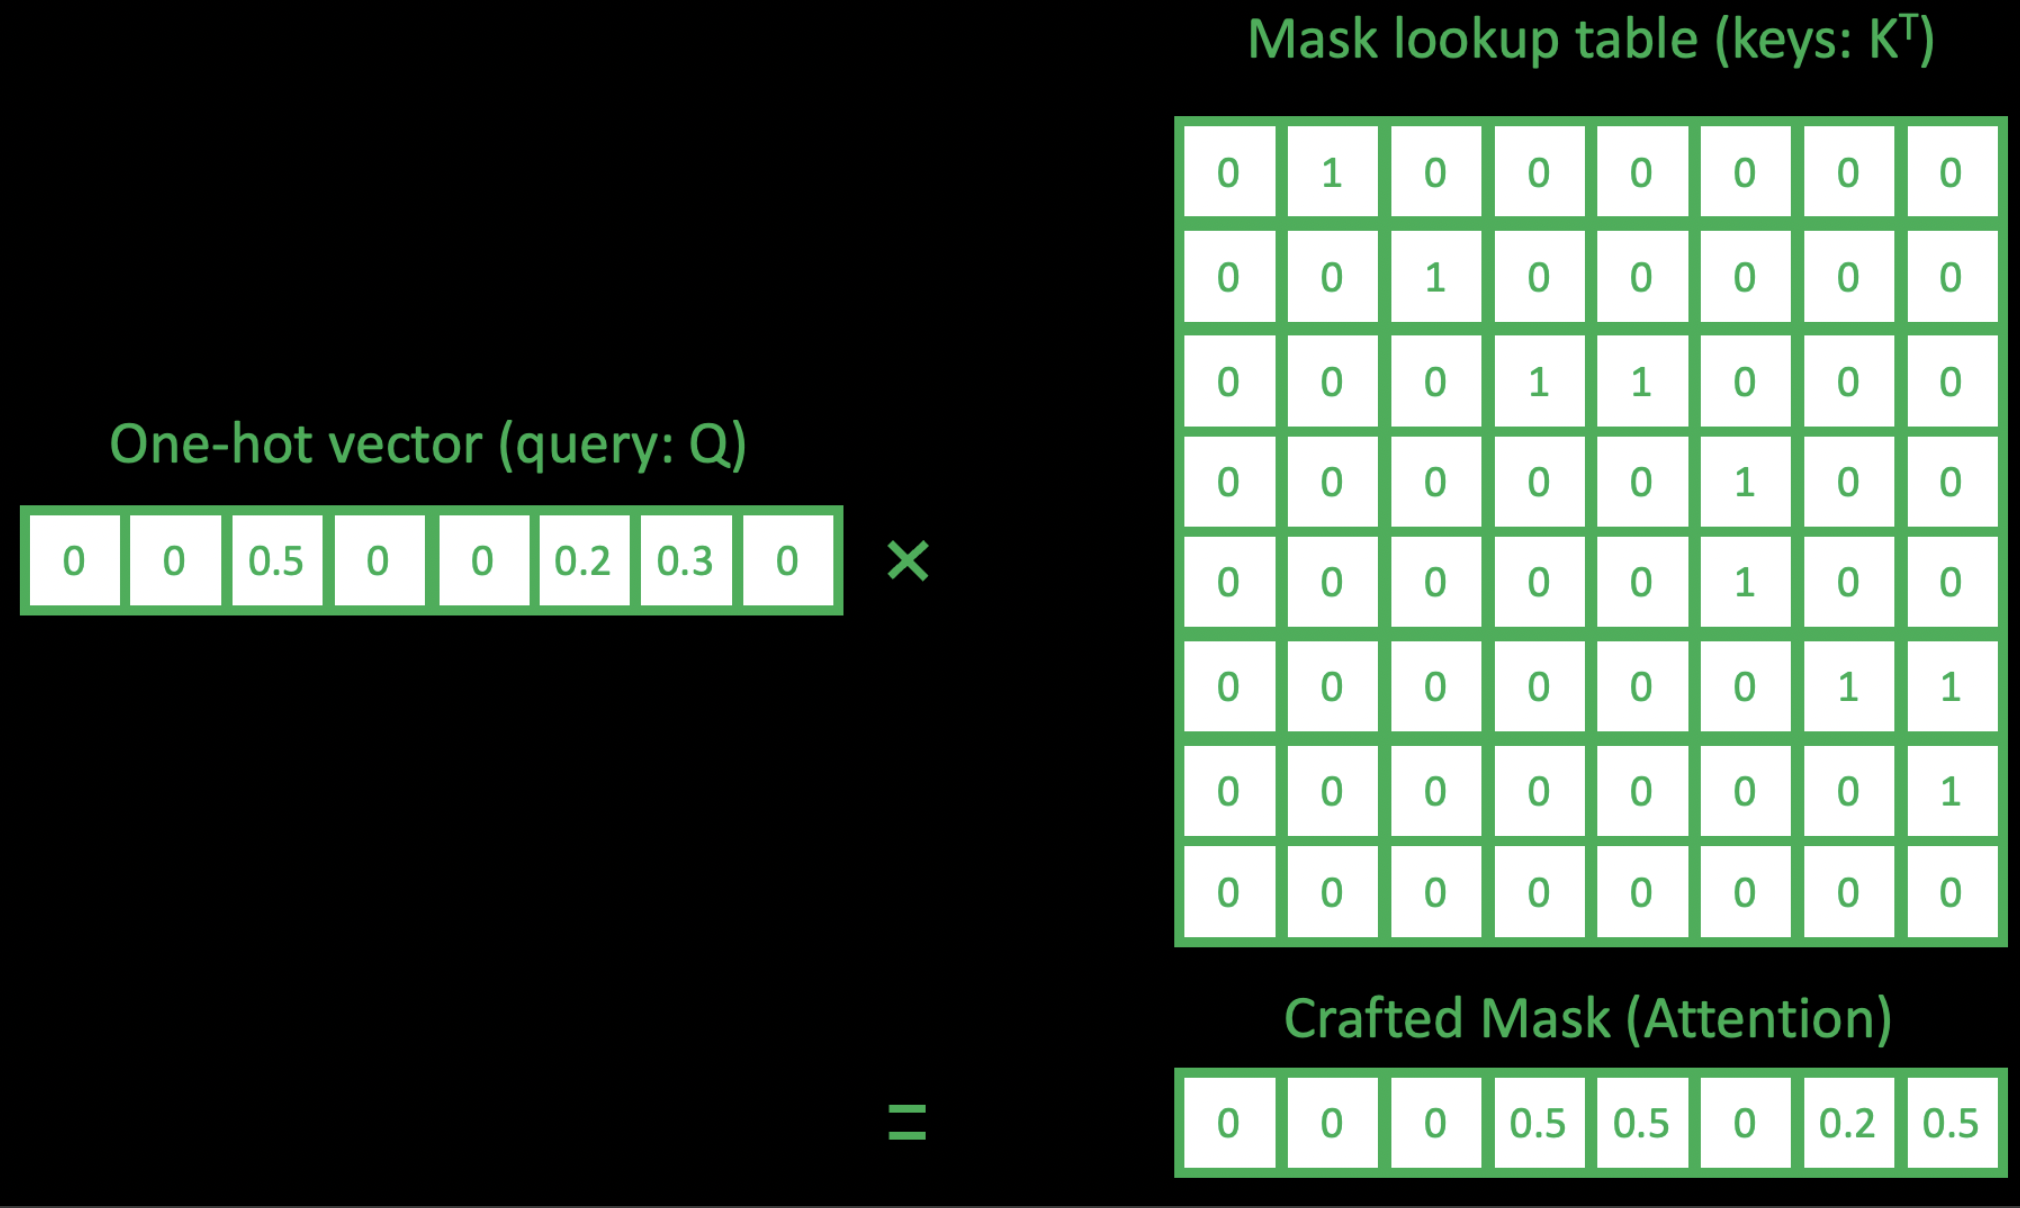

Khi chúng ta nhân 1 vector được lấy từ ma trận $Q$ với ma trận $K^T$ chúng ta sẽ được kết quả là tổng của ba hàng 3, 6, 7 cùng với các trọng số tương ứng 0.5, 0.2, 0.3. 
Chúng ta có thể diễn giải kết quả của phép nhân này như sau: Query $Q$ bảo mô hình tạo ra một **Key mask** mới từ tổng của 50% vector thứ 3, 20% vector thứ 6, và 30% vector thứ 7. Trên thực tế ma trận $Q$ và ma trận $K^T$ đều được học từ mô hình, kết quả của phép nhân này cho cúng ta một bộ những **Key masks.** Chính những Key masks này sẽ cho mô hình biết được cần tập trung (**Attention**) vào những Value: $V$ nào.

### **(b) Hàm Softmax**

Sau phép nhân ma trận $QK^T$ kết quả trả về thường không tuân theo một phân phối xác suất (Kết quả của hình minh hoạ phía trên có tổng lớn hơn 1). Việc này làm cho mô hình không ổn định.
Hàm **Softmax** có tác dụng kéo những giá trị về một phân phối xác suất có tổng bằng 1.

### **(c) Scaling**


Hàm **Softmax** rất nhạy cảm với những tập giá trị có phương sai lớn. Trong một số trường hợp, sử dụng hàm softmax không đúng cách sẽ dẫn đến mô hình học chậm, hay thậm chí dừng việc học.
Việc chia $QK^T$ cho $\sqrt{d_k}$ với $d_k$ là số chiều (dimension) của vector kết quả giúp giảm phương sai của các giá trị về gần bằng 1 (Phân phối Standard Normal)

## **4. Skip Connection**

### **(a) Skip connection**

Skip connection giúp cho dòng chảy đạo hàm trong mô hình được trơn tru hơn. Nếu như có bất kỳ vấn đề nào xảy ra trong quá trình tính toán đạo hàm lan truyền ngược ở trục mô hình chính, Skip connection giống như một con đường tắt nhằm đảm bảo mô hình vẫn có thể tiếp tục huấn luyện hiệu quả. Điều này càng đúng hơn đối với những mô hình ’sâu’ như Transformer: có nhiều khối Encoder, Decoder chồng lên nhau, nếu có bất kỳ khối nào hoạt động không hiệu quả Skip connection sẽ giúp đảm bảo dong chảy đạo hàm được ổn định đồng thời giữ lại được những thông tin gốc để truyền vào những khối phía sau.

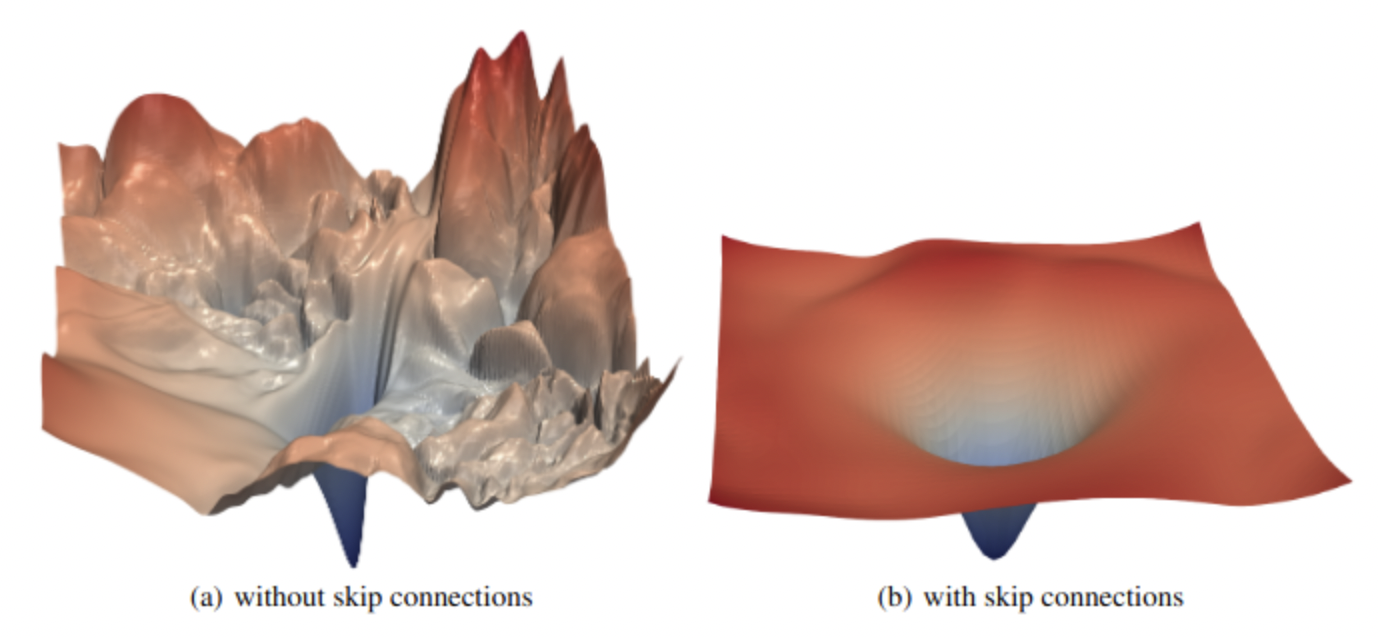

### **(b) Layer Norm**

Các hàm như Softmax, ReLU rất nhạy cảm với sự phân bố dữ liệu. Mục đích của **Layer Norm** là chuyển dịch dữ liệu về phân phối chuẩn - Standard Normal (trung bình = 0, độ lệch chuẩn = 1, việc này giúp cho mô hình hoạt động ổn định hơn.

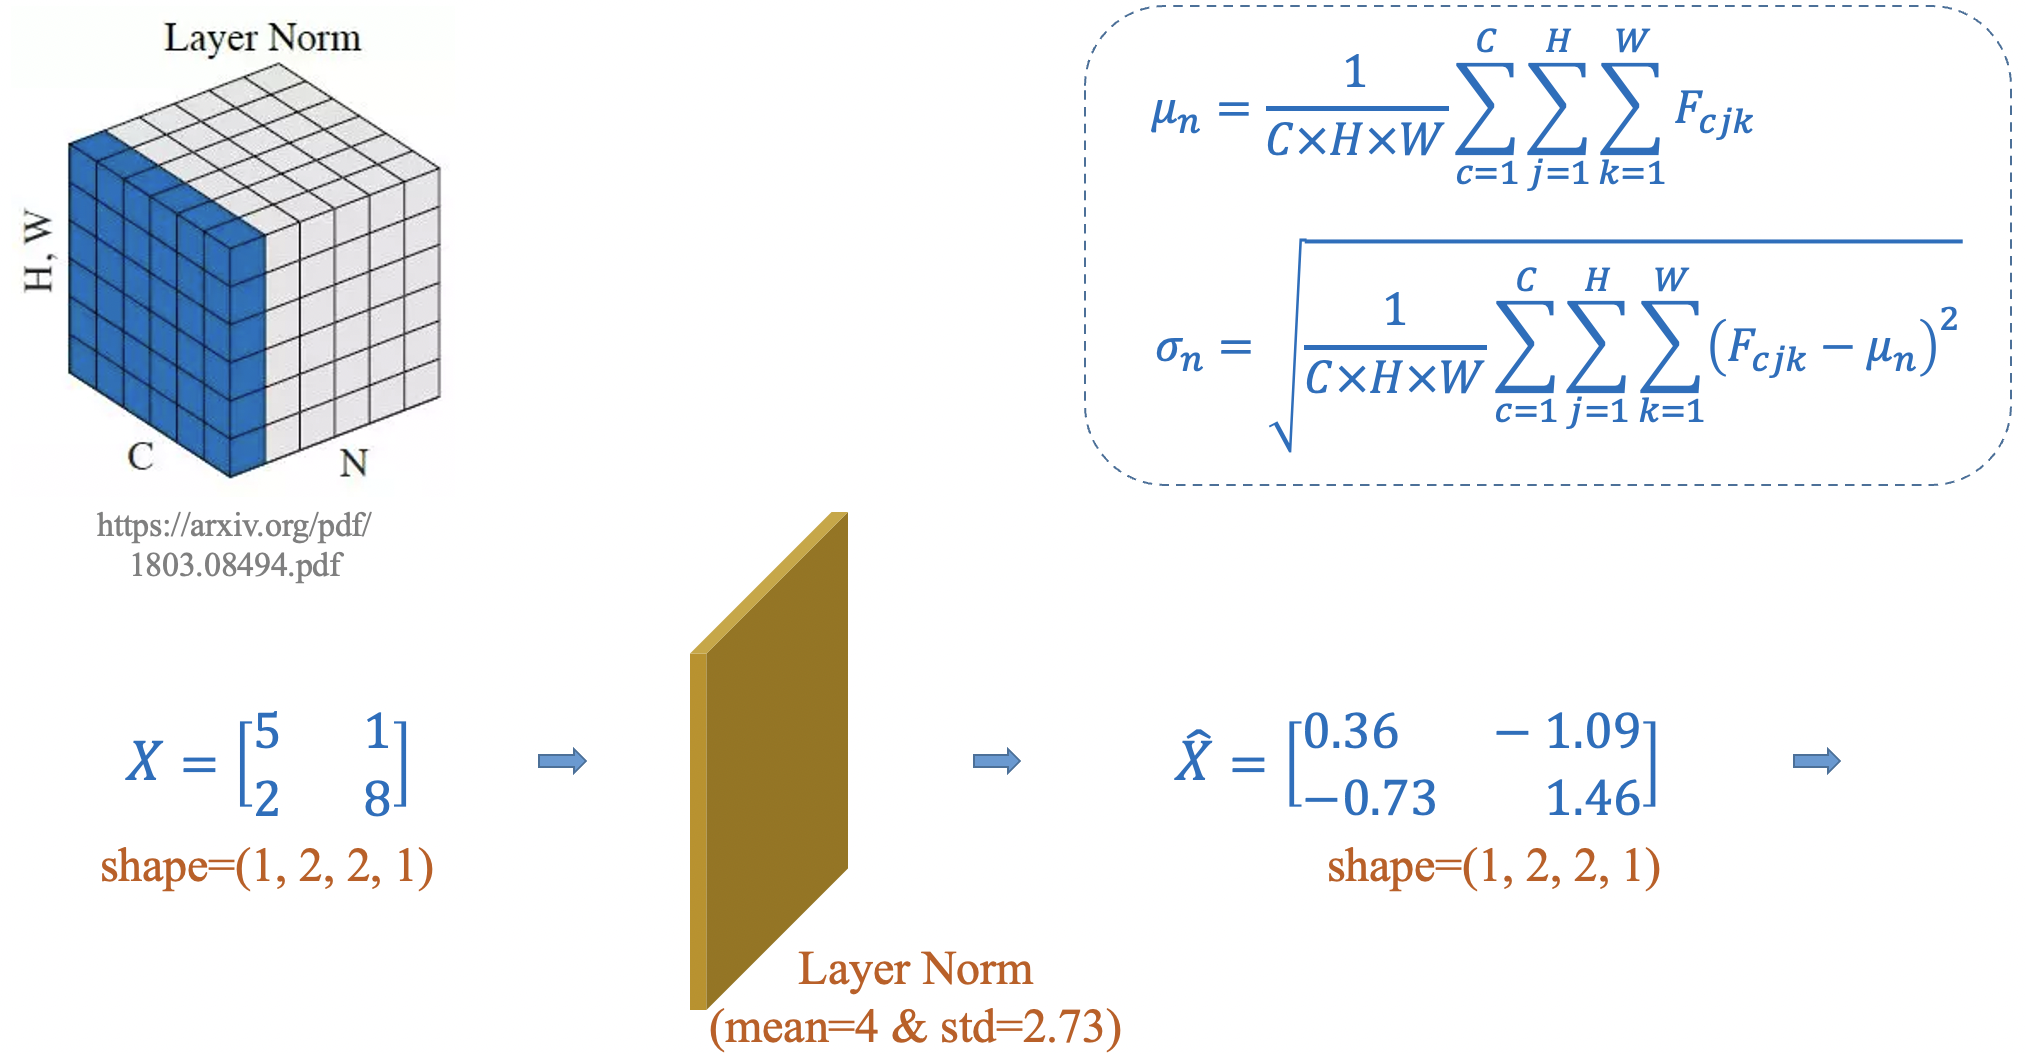

# **Phần 2: Text Generation**

**Text Generation** là một trong các dạng bài toán thuộc lĩnh vực xử lý ngôn ngữ tự nhiên hiện đang rất được cộng đồng quan tâm, với khả năng tạo ra các câu từ mới dựa trên dữ liệu đầu vào. Chính bởi các kết quả trả về mang tính "sáng tạo", đáp ứng được các nhu cầu bài toán khác nhau từ mô hình này mà nó đã và đang được ứng dụng vào các sản phẩm nổi tiếng hiện nay, điển hình nhất chính là
**ChatGPT**, một ứng dụng Chatbot đã tạo nên cơn sốt trên toàn thế giới thời gian qua.

Trong project này, chúng ta sẽ cùng triển khai một chương trình sử dụng mô hình **Text Generation** với chủ đề sinh thơ theo thể thơ ngũ ngôn (thơ 5 chữ) Tiếng Việt dựa vào một dòng thơ đầu vào từ người dùng. Như vậy, **Input/Output** của chương trình là:
* **Input:** Một chuỗi gồm 5 từ (tượng trưng cho dòng đầu tiên của bài thơ).
* **Output:** n dòng thơ tiếp theo (n tùy chọn).

Với mô hình sinh thơ, ta sẽ xây dựng theo mô hình transformer (sử dụng cả 2 phần encoder và decoder). Kiến trúc mô hình **Transformer** được mô tả theo ảnh dưới đây:

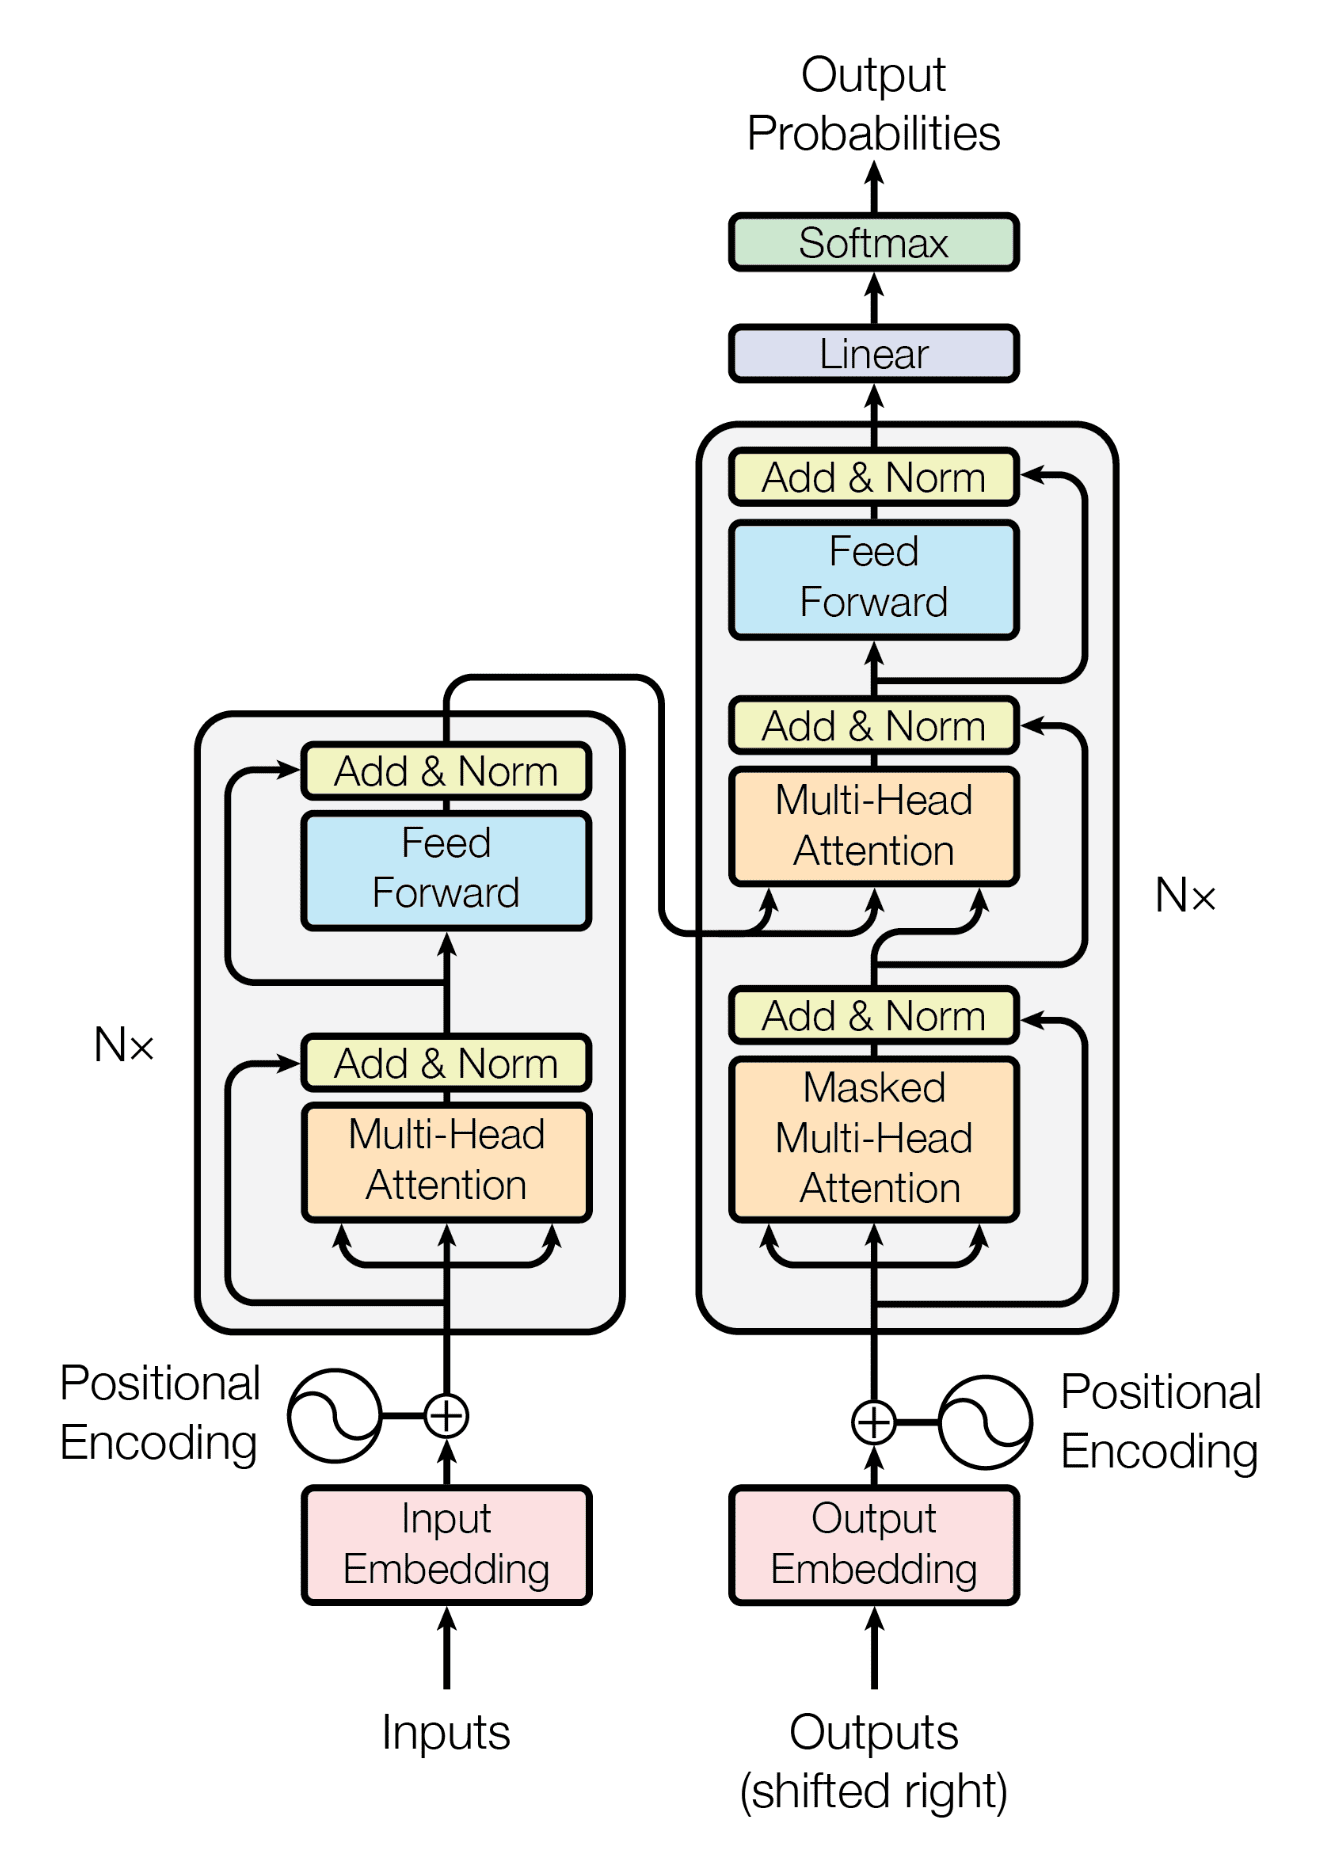

## **1. Thu thập dữ liệu**

Để huấn luyện được mô hình với Input/Output theo đúng như yêu cầu đã đề ra ở phần trước, chúng ta cần thu thập vào xây dựng một bộ dữ liệu theo đúng mô tả. Đối với dữ liệu thơ, có rất nhiều trang web tổng hợp các văn thơ của Việt Nam cũng như thế giới. Tuy nhiên ở project này, ta sẽ thu thập các văn thơ ngũ ngôn trên trang web **thivien.net**, một trang web lớn chuyên tổng hợp các văn thơ gồm đủ các thể loại của Việt Nam.

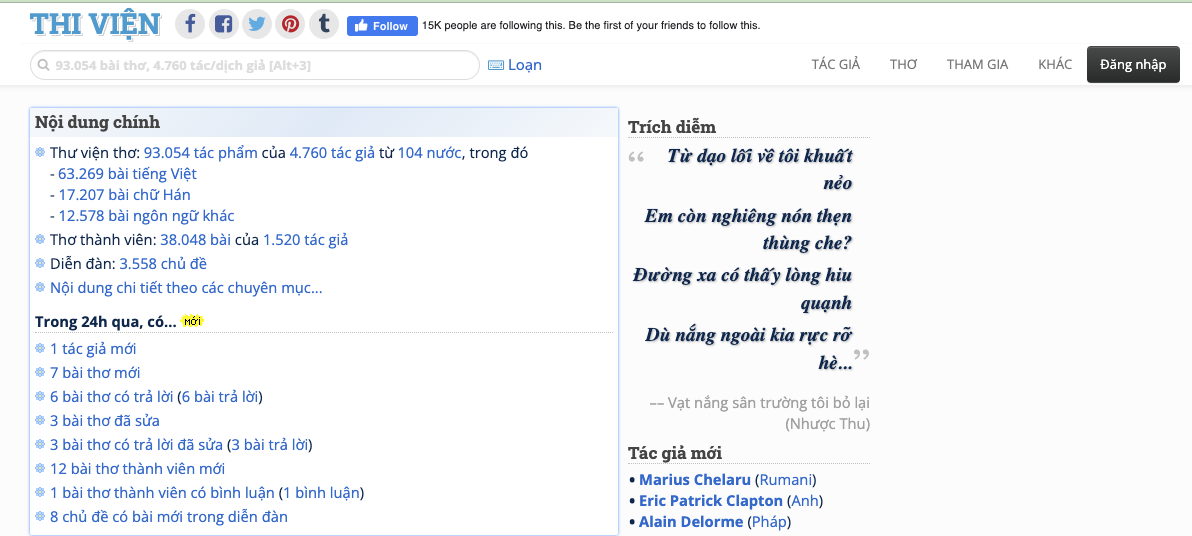

Có rất nhiều thư viện Python giúp ta có thể tương tác và trích xuất thông tin từ trang web một cách dễ dàng. Song ở project này, ta sẽ dùng thư viện **Selenium** để thực hiện việc thu thập dữ liệu trên Google Colab. Các bước thực hiện như sau:

###**(a) Tải thư viện Selenium:** 
Với môi trường máy tính cá nhân, ta đơn giản cài đặt bằng dòng lệnh **pip install selenium webdriver_manager.** Tuy nhiên với môi trường Google Colab, ta sẽ có cách cài đặt phức tạp hơn (chi tiết coi tại [đây](https://colab.research.google.com/drive/1Sj4UdHdxUve2XelGU6nJWELcx_-8xoqI?usp=sharing)), ta copy và chạy đoạn code bên dưới trong Colab

### **(b) Import các thư viện cần thiết:**

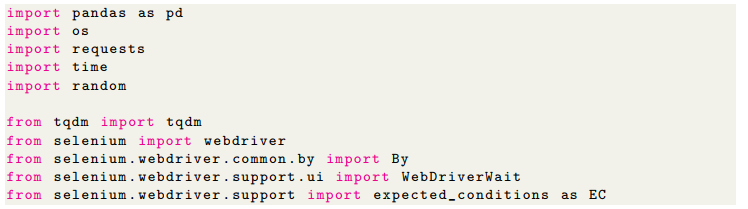


### **(c) Khởi tạo driver:**

Với selenium, ta có thể hiểu đơn giản rằng việc truy cập vào một trang web sẽ được thực hiện như chính chúng ta sử dụng trình duyệt web hằng ngày. Đầu tiên, ta khởi tạo một driver sử dụng đoạn code sau:

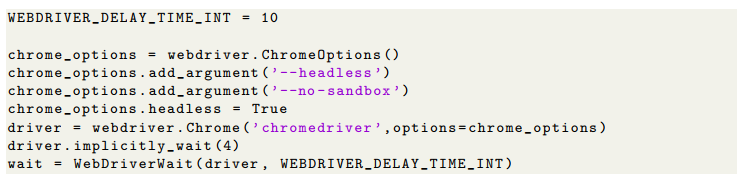

Driver trong Selenium đóng vai trò như trình duyệt web, giúp ta thực hiện các thao tác như truy cập vào trang web dựa vào đường dẫn, thao tác chuyển trang...

### **(d) Phân tích nội dung cần trích xuất:**
Để việc triển khai code được thuận lợi, ta cần xác định rõ kiến trúc html của trang web cũng như các thành phần, nội dung mà ta mong muốn trích xuất. Trong project, mục tiêu của chúng ta chính là các bài thơ có thể thơ ngũ ngôn Tiếng Việt. Vì vậy, một cách tìm nhanh chóng nhất đó là ta nên tìm đến trang tìm kiếm, từ đó sử dụng selenium để duyệt qua toàn bộ các bài viết được liệt kê trong trang tìm kiếm đó. Trong **thivien.net**, ta chọn mục **Tìm thơ...** để đến trang này.

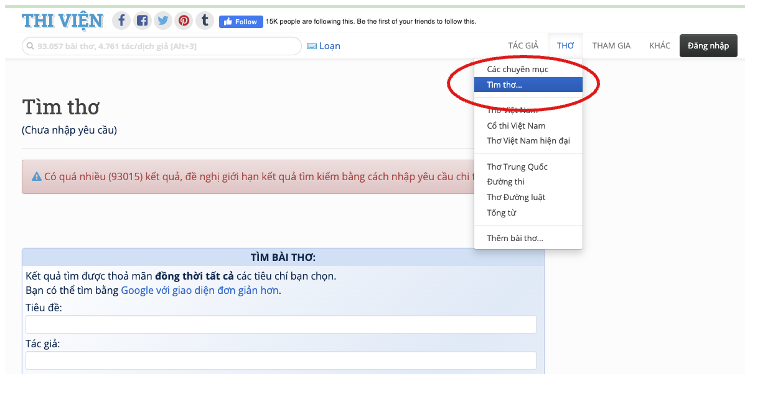

Sau đó, ta hãy điền một số thông tin trong bảng **TÌM BÀI THƠ:**, ở đây ta chỉ cần quan tâm đến trường thông tin **Thể thơ:** được chọn vào **"Thơ mới năm chữ"**. Sau khi bấm tìm kiếm, một trang web với các bài thơ với thể thơ ngũ ngôn xuất hiện.

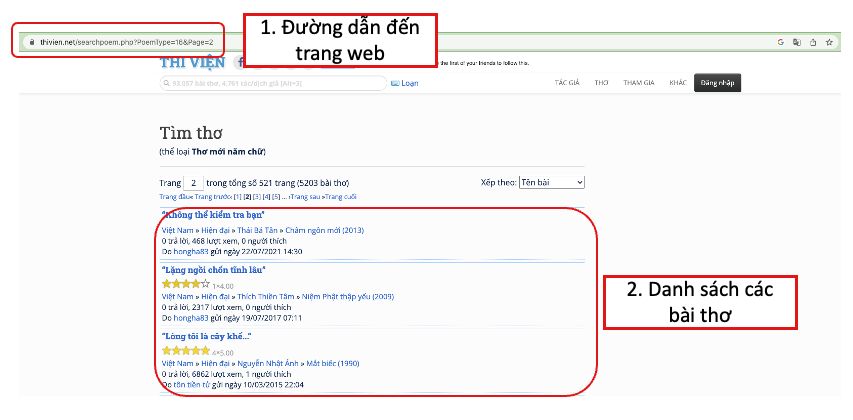


Tại đây, ta đã có được thông tin đường dẫn của trang web (mainpage_url). Chúng ta sẽ sử dụng driver đã Định nghĩa ở trên để truy cập vào trang này bằng lệnh **driver.get()**:

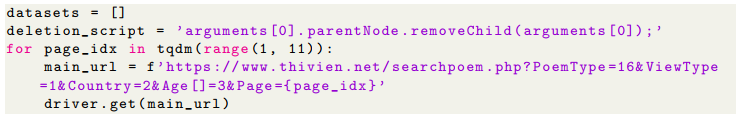

Nhận thấy đường dẫn trang web có chứa các trường thông tin để ta có thể di chuyển qua lại tại các trang tiếp theo của bảng tìm kiếm (‘Page=2‘ tức đang ở trang 2 của bảng). Vì vậy ta có thể tận dụng điều này để tạo một vòng lặp lặp qua từng trang một cách tự động (với đoạn code trên ta sẽ duyệt từ trang thứ 1 đến trang thứ 10).

Ta tiếp tục phân tích các thành phần ta cần trích xuất đối với một trang thơ thông qua việc đọc cấu trúc html của trang web (cấu trúc html của trang web có thể được tìm thấy thông qua tính năng Inspect trên trình duyệt). Nhận thấy, thông tin duy nhất ta quan tâm đó chính là nội dung bài thơ. Song, để tiện cho các tác vụ sau này nếu có, ta sẽ trích xuất thêm các thông tin khác của bài thơ như Tựa đề, Nguồn...

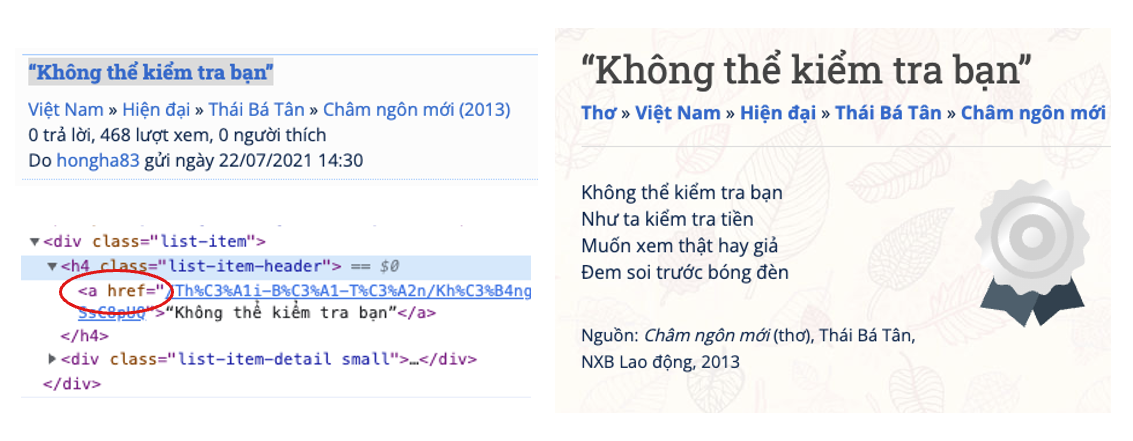

Như vậy, mỗi bài thơ được liệt kê tại trang tìm kiếm là một thẻ *\<div\>*, bên trong có chứa đường dẫn đến trang chứa bài thơ chính khi ta click chuột vào. Từ đây, ta dễ dàng truy cập vào mỗi bài thơ bằng cách đọc đường dẫn của thuộc tính **'href'** chứa tại thẻ *\<a\>* (như hình). Để thực hiện được điều này, đầu tiên ta cần đọc được thẻ html chứa bảng dữ liệu.

Trong Selenium, có nhiều cách để xác định và đọc thẻ html từ trang web thông qua hai phương thức **driver.find_element()** (tìm một thẻ khớp) và **driver.find_elements()** (tìm nhiều thẻ khớp) song tìm kiếm bằng XPATH là một cách nhanh chóng nhất. Ở đây, ta quan tâm đến các thẻ div chứa thông tin bài thơ nên ta sẽ dùng find_elements() để tìm toàn bộ các thẻ này. Và với danh sách các thẻ của từng bài thơ (**content_tags**), ta đã có thể truy cập vào nội dung chi tiết của từng bài thơ.

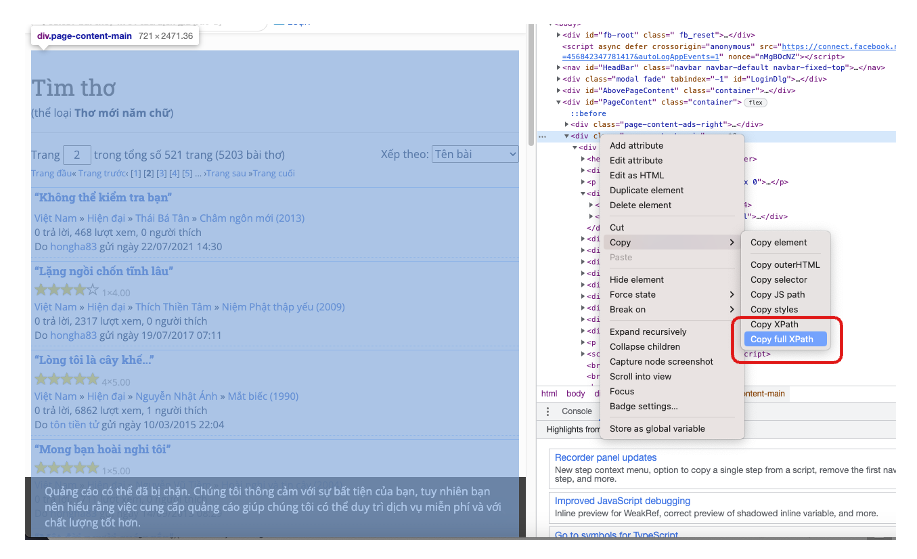

### **(e) Thực hiện trích xuất nội dung thơ:**
Cuối cùng, với từng thẻ html của trang thơ, ta sẽ thực hiện trích xuất các thông tin mà ta đã xác định (gồm Nội dung bài thơ, Tựa đề, Nguồn) của bài thơ tương ứng. Các thông tin này sẽ được lưu thành một dictionary và đẩy vào một list lưu trữ chung (**datasets**)

Các kỹ thuật tại bước này đều xoay quanh việc tìm kiếm bằng XPATH kèm theo một số logic python phát sinh trong quá trình thử nghiệm code, các bạn nên đọc qua từng dòng cũng như kiểm nghiệm lại giá trị các biến dữ liệu để có thể hiệu tường tận các bước trích xuất trên. Thông qua đó, các bạn cũng có thể áp dụng để thu thập dữ liệu từ các trang web khác theo nhu cầu của các bạn (Ví dụ: thu thập các bài thơ lục bát tại **thivien.net...**)

### **(f) Lưu bộ dữ liệu thành file .csv:** 
Sau khi hoàn tất giai đoạn thu thập trên, ta sẽ có một danh sách các dictionary (record) chứa thông tin của một bài thơ. Lúc này, để thuận tiện trong việc lưu trữ, ta sẽ lưu danh sách này thành một file **.csv**.

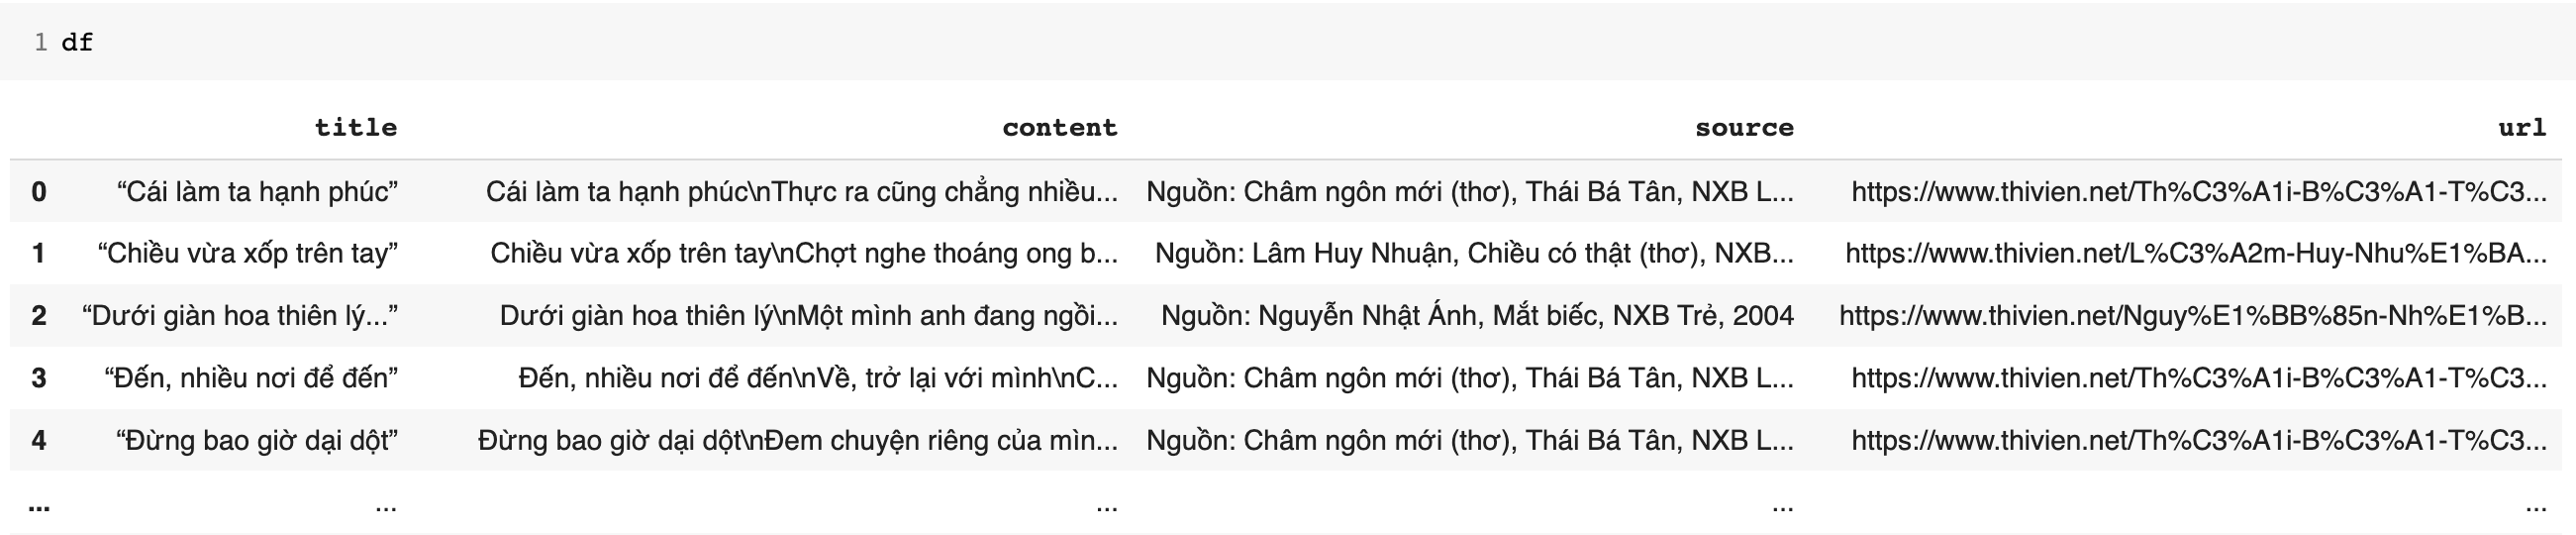

Trong phần code ví dụ trên, ta chỉ cài đặt để thu thập 10 trang đầu tiên trong trang tìm kiếm (vì trang web giới hạn số trang hiển thị). Các bạn muốn thu thập thêm dữ liệu có thể điều chỉnh lại trang tìm kiếm với các filter khác để tìm được những bài thơ mới hơn.

## **2. Chuẩn bị dữ liệu**

Sau khi đã hoàn tất thu thập một số lượng dữ liệu nhất định, ta tiến hành xử
lý bộ dữ liệu đã thu thập được để phù hợp với Input/Output yêu cầu của mô hình transformer.

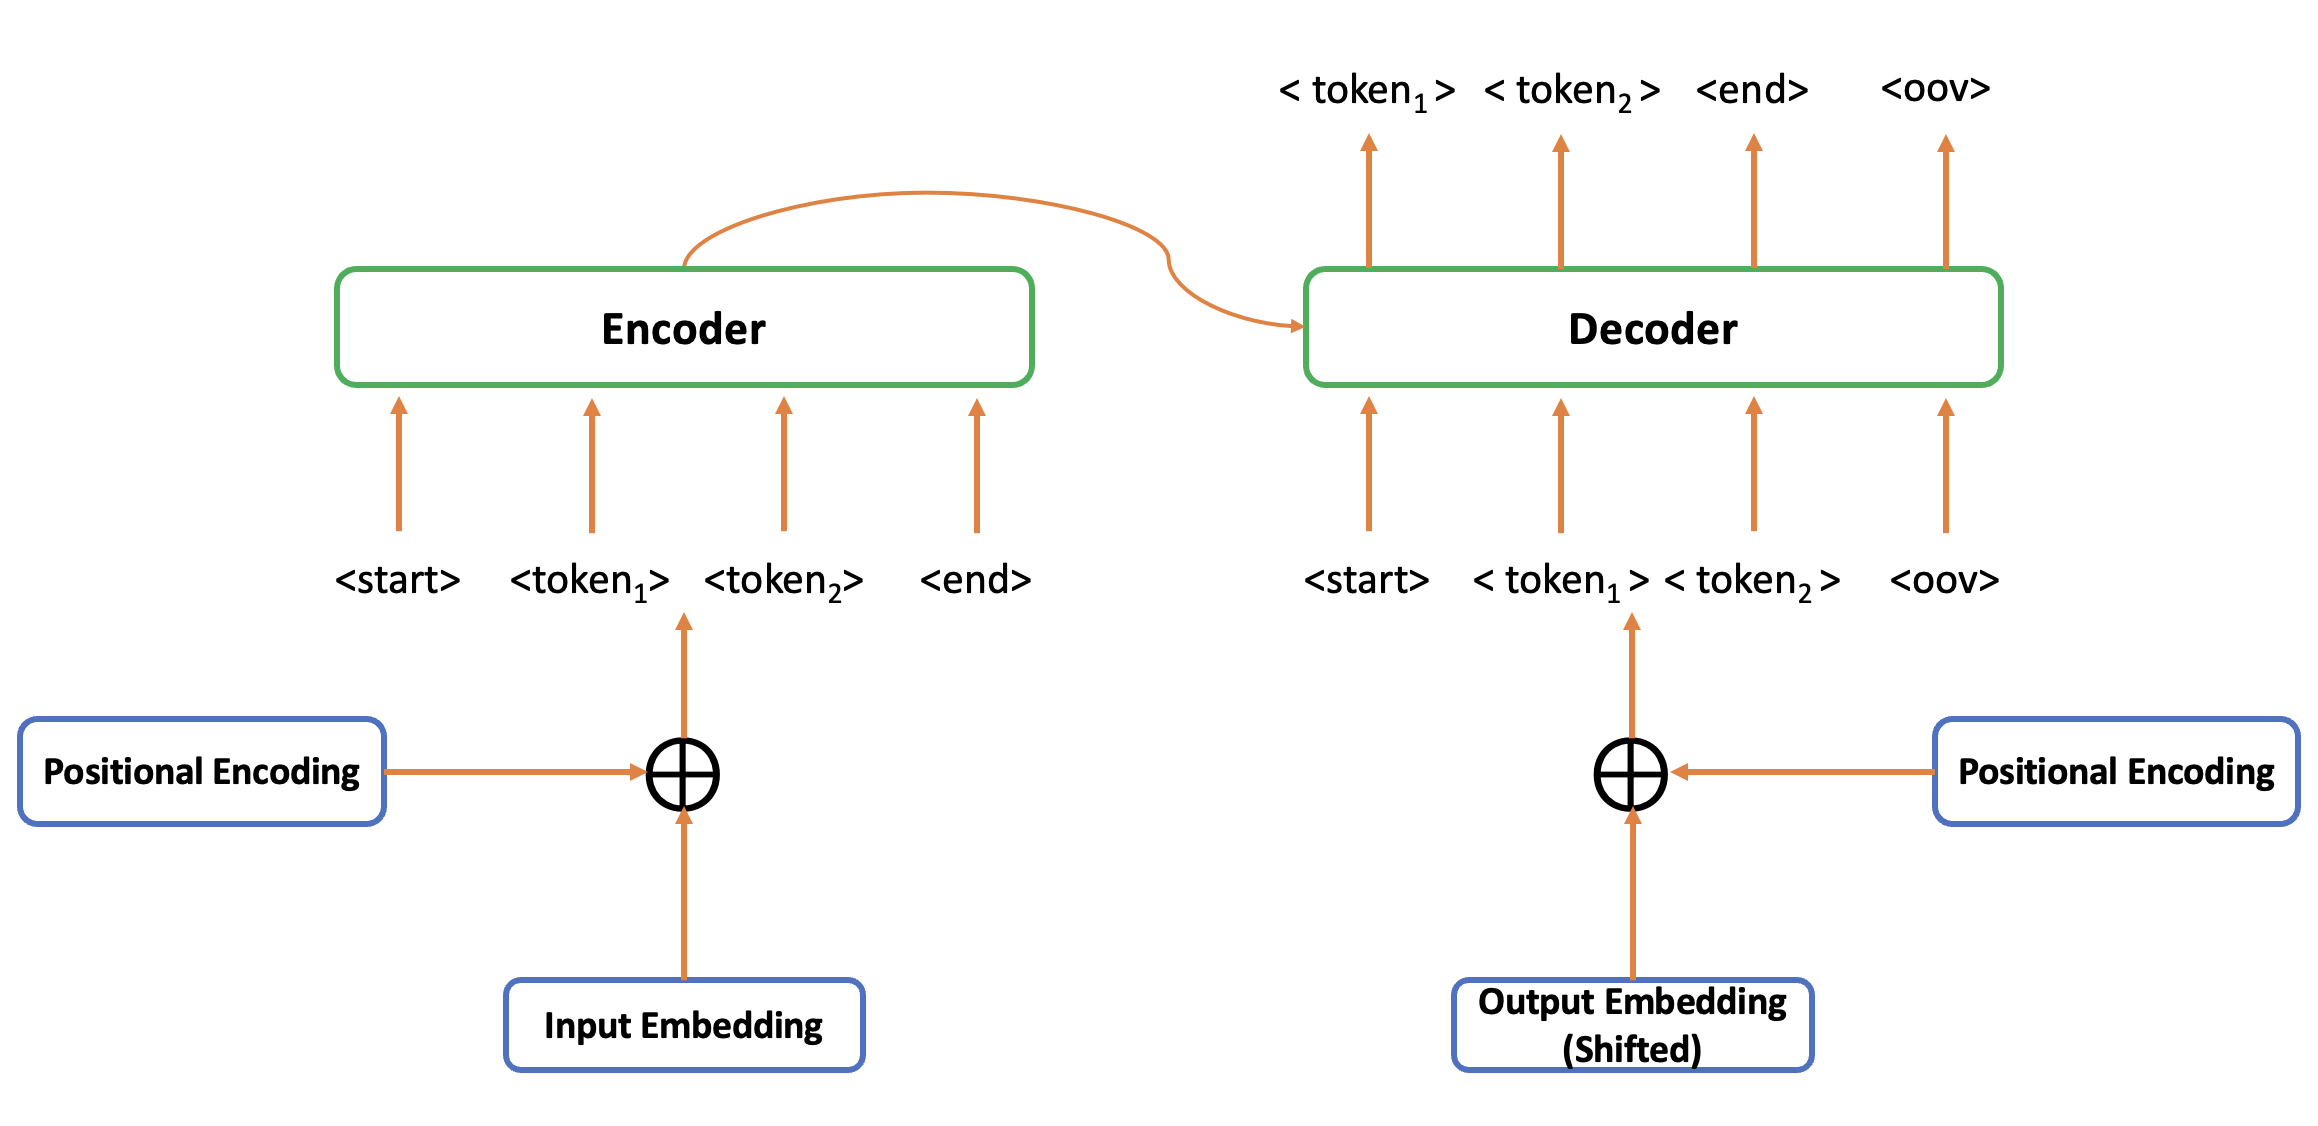

### **(a) Download dataset và import các thư viện cần thiết**

In [1]:
!gdown --id 1kh0hnT_PYbRDyUkfjwkSHv-VvGNA2H08

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1kh0hnT_PYbRDyUkfjwkSHv-VvGNA2H08
To: /content/poem_dataset.zip
100% 20.3k/20.3k [00:00<00:00, 28.9MB/s]


In [2]:
!unzip './poem_dataset.zip'

Archive:  ./poem_dataset.zip
  inflating: poem_dataset.csv        


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import random

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

RANDOM_SEED = 1
tf.random.set_seed(RANDOM_SEED)

### **(b) Chuẩn hóa dữ liệu:** 
Tương tự các bài toán khác liên quan đến dữ liệu văn bản, chúng ta cũng sẽ thực hiện chuẩn hóa dữ liệu. Các kỹ thuật chính được áp dụng tại đây gồm: chuyển chữ viết thường (lowercasing), strip, xóa dấu câu (punctuation removal). Bên cạnh đó, dữ liệu đầu vào của mô hình transformer mong muốn có hai thêm 2 token **\<start\>** và **\<end\>** vào đầu và cuối mỗi điểm dữ liệu, vì vậy ta cũng sẽ xử lý vấn đề này trong hàm chuẩn hóa. Hàm chuẩn hóa văn bản được định nghĩa như sau:

In [4]:
def text_normalize(text):
    text = text.lower()
    text = text.strip() 
    text = re.sub(r'[^\w\s\n]', '', text)
    text = text.replace('\n\n', '\n')
    text = '\n'.join(['<start> ' + line + ' <end>' for line in text.split('\n') if line != '' and len(line.split()) == 5])
 
    return text

###**(c) Đọc dữ liệu:** 
Từ file **poem_dataset.csv**, ta đọc dữ liệu đã thu thập thành DataFrame:

In [5]:
BATCH_SIZE = 32
MAX_SEQ_LEN = 7
VOCAB_SIZE = 5000 

DATASET_PATH = './poem_dataset.csv'

df = pd.read_csv(DATASET_PATH, index_col=0)
df['content'] = df['content'].apply(lambda p: text_normalize(p))
corpus = df['content'].to_numpy()

### **(d) Xác định dữ liệu X, y:** 
Đầu tiên, ta tách bài thơ thành hai biến **X, y**. Vì mô hình sẽ sinh dòng thơ tiếp theo từ dòng thơ cho trước. Như vậy, khi duyệt qua một bài thơ **l** có **n** dòng,
$X = l[i]$ và $y = l[i + 1]$ $(0 <= i < n - 1)$.

In [6]:
X = []
y = []
for idx, row in df.iterrows():
    lines = row['content'].split('\n')
    lines = [line for line in lines if line != '']
    for idx in range(0, len(lines) - 1):
        input_sentence = lines[idx]
        output_sentence = lines[idx+1]

        X.append(input_sentence)
        y.append(output_sentence)

In [7]:
for idx in range(len(X))[:10]:
    print(f'Input: {X[idx]} => {y[idx]}')

Input: <start> cái làm ta hạnh phúc <end> => <start> thực ra cũng chẳng nhiều <end>
Input: <start> thực ra cũng chẳng nhiều <end> => <start> chỉ cần có ai đó <end>
Input: <start> chỉ cần có ai đó <end> => <start> để ta thầm thương yêu <end>
Input: <start> để ta thầm thương yêu <end> => <start> rồi thêm chút công việc <end>
Input: <start> rồi thêm chút công việc <end> => <start> cho ta làm hàng ngày <end>
Input: <start> cho ta làm hàng ngày <end> => <start> cuối cùng chút mơ mộng <end>
Input: <start> cuối cùng chút mơ mộng <end> => <start> để đưa ta lên mây <end>
Input: <start> chiều vừa xốp trên tay <end> => <start> chợt nghe thoáng ong bay <end>
Input: <start> chợt nghe thoáng ong bay <end> => <start> có ai vừa chết nhỉ <end>
Input: <start> có ai vừa chết nhỉ <end> => <start> mây thắt tang trăng gầy <end>


### **(e) Tokenization:** 
Để đưa các dòng thơ vào mô hình transformer huấn luyện, ta cần phải chuyển đổi thành các vector với các từ lúc này được biểu diễn dưới dạng số chỉ mục có nó trong bộ từ vựng (các từ không nằm trong bộ từ vựng được mã hóa thành <oov>). Vì vậy, ta sẽ dùng tokenizer của tensorflow để tokenize toàn bộ corpus, sử dụng đoạn lệnh sau:

In [8]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='', oov_token="<OOV>")
tokenizer.fit_on_texts(corpus)

VOCAB_SIZE = len(tokenizer.word_index) + 1

Lưu ý rằng cần phải cài đặt **filters=""** do ta đã xóa dấu câu ở bước chuẩn hóa trước đó, việc xóa dấu câu một lần nữa sẽ khiến các token **\<start\>** và **\<end\>** bị hỏng.

**(f) Padding:** Ta cần đảm bảo rằng các chuỗi vector Input/Output luôn phải có kích thước tương đồng nhau. Để thực hiện việc này ta dùng hàm **pad_sequences()** trong tensorflow.
Khi huấn luyện mô hình transformer, ta cần đưa vào mô hình dữ liệu cho cả phần encoder và decoder. Ở phần encoder, dữ liệu đầu vào chính là chuỗi đầu X. Về phần decoder, ta sẽ tách label y làm 2 chuỗi khác nhau, chuỗi đầu chứa token **\<start\>** và chuỗi chứa token **\<end\>**. Khi đó, chuỗi token **\<start\>** sẽ làm input cho decoder, và chuỗi token **\<end\>** sẽ làm label.

In [9]:
def prepare_output_sequences(y_sequences):
    y_inputs = pad_sequences([y_seq[:-1] for y_seq in y_sequences], maxlen=MAX_SEQ_LEN, truncating='pre', padding='post')
    y_outputs = pad_sequences([y_seq[1:] for y_seq in y_sequences], maxlen=MAX_SEQ_LEN, truncating='pre', padding='post')

    return y_inputs, y_outputs

X_sequences = tokenizer.texts_to_sequences(X)
X_padded_sequences = pad_sequences(X_sequences, maxlen=MAX_SEQ_LEN, truncating='pre', padding='post')

y_sequences = tokenizer.texts_to_sequences(y)
y_inputs, y_outputs = prepare_output_sequences(y_sequences)

### **(g) Chia bộ dữ liệu train/val/test:** 
Chia bộ dữ liệu huấn luyện theo tỉ lệ 7:2:1

In [10]:
n_samples = len(X_padded_sequences)
train_len = int(n_samples * 0.7)
val_len = int(n_samples * 0.2)
test_len = n_samples - train_len - val_len

# Shuffle 
np.random.seed(1)
idxs = np.arange(n_samples)
idxs = np.random.permutation(idxs)

X_padded_sequences = X_padded_sequences[idxs]
y_inputs = y_inputs[idxs]
y_outputs = y_outputs[idxs]

# Split the data into train, validation, and test sets
X_train_seq, y_train_input, y_train_output = X_padded_sequences[:train_len], y_inputs[:train_len], y_outputs[:train_len]
X_val_seq, y_val_input, y_val_output = X_padded_sequences[train_len:train_len+val_len], y_inputs[train_len:train_len+val_len], y_outputs[train_len:train_len+val_len]
X_test_seq, y_test_input, y_test_output = X_padded_sequences[train_len+val_len:], y_inputs[train_len+val_len:], y_outputs[train_len+val_len:]

### **(h) Tạo tf.data.Dataset:** 
Cuối cùng, để tối ưu quá trình đọc dữ liệu khi huấn luyện, ta chuyển đổi dataset thành **tf.data.Dataset**

In [11]:
train_ds = tf.data.Dataset.from_tensor_slices(((X_train_seq, y_train_input), y_train_output)).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices(((X_val_seq, y_val_input), y_val_output)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices(((X_test_seq, y_test_input), y_test_output)).batch(BATCH_SIZE)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## **3. Xây dựng mô hình**

### **(a) Định nghĩa Positional Encoding Layer**

In [12]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

### **(b) Định nghĩa các Self-attention based Layer**

In [13]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

In [14]:
class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

In [15]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        
        return x

In [16]:
class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        
        return x

### **(c) Định nghĩa FeedForward Network Layer**

In [17]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model),
        tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x

### **(d) Định nghĩa Transformer Encoder Block**

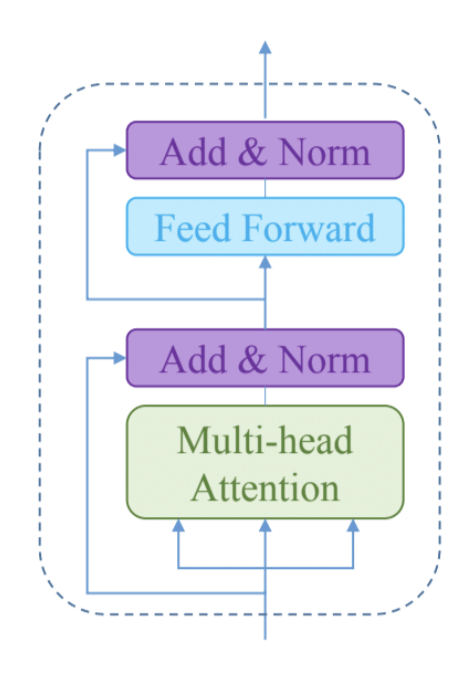

In [18]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

In [19]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads,
                dff, vocab_size, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(
            vocab_size=vocab_size, d_model=d_model)

        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                        num_heads=num_heads,
                        dff=dff,
                        dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        # `x` is token-IDs shape: (batch, seq_len)
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

### **(e) Định nghĩa Transformer Decoder Block:**

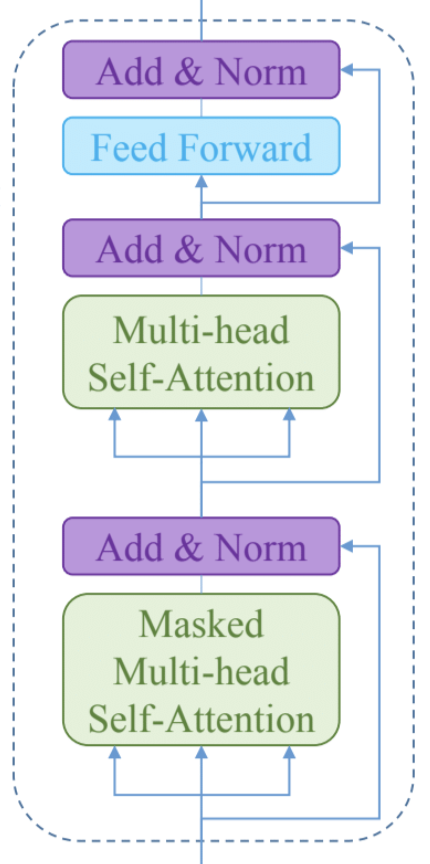

In [20]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,
                *,
                d_model,
                num_heads,
                dff,
                dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)

        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.cross_attention.last_attn_scores

        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x

In [21]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
                dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                                d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(d_model=d_model, num_heads=num_heads,
                        dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]

        self.last_attn_scores = None

    def call(self, x, context):
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, context)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

### **(f) Định nghĩa Transformer Model**

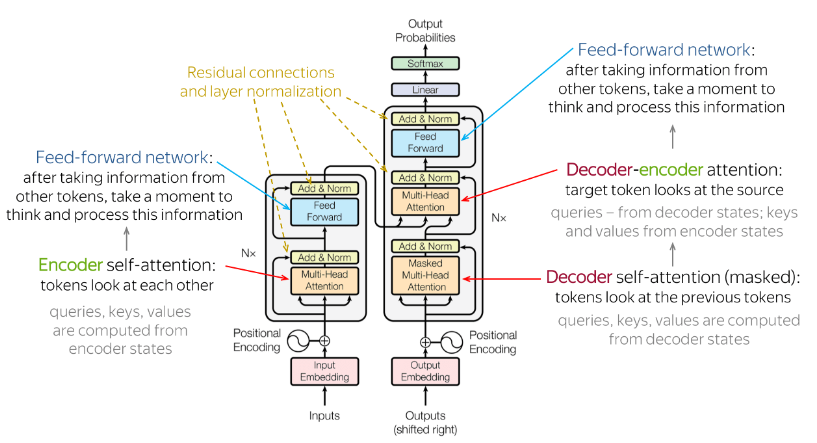

In [22]:
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff,
                vocab_size, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                            num_heads=num_heads, dff=dff,
                            vocab_size=vocab_size,
                            dropout_rate=dropout_rate)

        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                            num_heads=num_heads, dff=dff,
                            vocab_size=vocab_size,
                            dropout_rate=dropout_rate)

        self.final_layer = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        context, x  = inputs

        context = self.encoder(context)  # (batch_size, context_len, d_model)

        x = self.decoder(x, context)  # (batch_size, target_len, d_model)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass

        # Return the final output and the attention weights.
        return logits

### **(g) Khai báo mô hình transformer:** 
Với class transformer model đã định nghĩa ở trên, ta thực hiện khởi tạo mô hình kèm với một số siêu tham số.
Trong đó:
* **N_LAYERS:** Số lượng transformer encoder-decoder block.
* **D_MODEL:** Là embedding dims của một token được biểu diễn trong transformer.
* **D_FF:** Số lượng node tại hidden layer của FeedForward Network layer.
* **N_HEADS:** Số lượng head trong multi-head attention layers.
* **DROPOUT_RATE:** Tỉ lệ dropout tại các layer Dropout() trong transformer.
* **VOCAB_SIZE:** Kích thước bộ từ vựng


In [23]:
N_LAYERS = 4
D_MODEL = 128
D_FF = 512
N_HEADS = 8
DROPOUT_RATE = 0.2

In [24]:
transformer = Transformer(
    num_layers=N_LAYERS,
    d_model=D_MODEL,
    num_heads=N_HEADS,
    dff=D_FF,
    vocab_size=VOCAB_SIZE,
    dropout_rate=DROPOUT_RATE
)

In [25]:
batches = train_ds.take(2)
for batch in batches:
    X_try, y_try = batch[0], batch[1]
    break

In [26]:
output = transformer(X_try)
output.shape

TensorShape([32, 7, 1471])

In [27]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  2827136   
                                                                 
 decoder (Decoder)           multiple                  4938112   
                                                                 
 dense_16 (Dense)            multiple                  189759    
                                                                 
Total params: 7,955,007
Trainable params: 7,955,007
Non-trainable params: 0
_________________________________________________________________


## **4. Cấu hình mô hình**

Sau khi có mô hình, ta cần cấu hình thêm một số thông tin cơ bản khác cho model bao gồm hàm loss, thuật toán tối ưu, độ đo đánh giá... Đối với transformer, sẽ có một số tùy chỉnh phức tạp hơn như sau: 
* **Learning Rate:** Sử dụng kỹ thuật LearningRate Scheduler (tự động điều chỉnh lại giá trị learning rate trong quá trình huấn luyện).

In [28]:
# Khai báo một số giá trị siêu tham số
EPOCHS = 50

In [29]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [30]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, 
    beta_1=0.9, 
    beta_2=0.98,
    epsilon=1e-9
)

* **Loss function:** Vì label được "padding" nên để giúp model chỉ tập trung vào các token có nghĩa, ta dùng Mask Loss

* **Accuracy:** Với lý do tương tự loss function, ta sẽ dùng Mask Accuracy

In [31]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)

    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

def compute_perplexity(logits, targets):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

    loss = loss_fn(targets, logits)

    perplexity = np.exp(np.mean(loss))

    return perplexity


def compute_bleu(predicted, targets):
    predicted_strings = []
    for seq in predicted:
        seq = np.argmax(seq, axis=1)
        string_seq = " ".join([tokenizer.sequences_to_texts([[token]])[0] for token in seq if token != 0])
        predicted_strings.append(string_seq)
    target_strings = []
    for seq in targets:
        seq = seq.numpy().tolist()
        string_seq = " ".join([tokenizer.sequences_to_texts([[token]])[0] for token in seq if token != 0])
        target_strings.append([string_seq])  

    bleu_score = corpus_bleu(target_strings, predicted_strings)

    return bleu_score

In [32]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy]
)

## **5. Thực hiện huấn luyện**

In [33]:
history = transformer.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)

Epoch 1/50
23/23 [==============================] - 54s 339ms/step - loss: 7.3340 - masked_accuracy: 4.5290e-04 - val_loss: 7.2070 - val_masked_accuracy: 0.0037
Epoch 2/50
23/23 [==============================] - 1s 44ms/step - loss: 7.0890 - masked_accuracy: 0.1053 - val_loss: 6.8698 - val_masked_accuracy: 0.1667
Epoch 3/50
23/23 [==============================] - 1s 42ms/step - loss: 6.8213 - masked_accuracy: 0.1667 - val_loss: 6.6869 - val_masked_accuracy: 0.1667
Epoch 4/50
23/23 [==============================] - 1s 41ms/step - loss: 6.6715 - masked_accuracy: 0.1667 - val_loss: 6.6092 - val_masked_accuracy: 0.1667
Epoch 5/50
23/23 [==============================] - 1s 41ms/step - loss: 6.5837 - masked_accuracy: 0.1667 - val_loss: 6.5568 - val_masked_accuracy: 0.1667
Epoch 6/50
23/23 [==============================] - 1s 41ms/step - loss: 6.5176 - masked_accuracy: 0.1667 - val_loss: 6.4989 - val_masked_accuracy: 0.1667
Epoch 7/50
23/23 [==============================] - 1s 41ms/step

## **6. Đánh giá và trực quan hoá**

In [34]:
# Đánh giá mô hình trên tập test
test_evaluation = transformer.evaluate(test_ds)

4/4 [==============================] - 0s 17ms/step - loss: 6.4487 - masked_accuracy: 0.1901


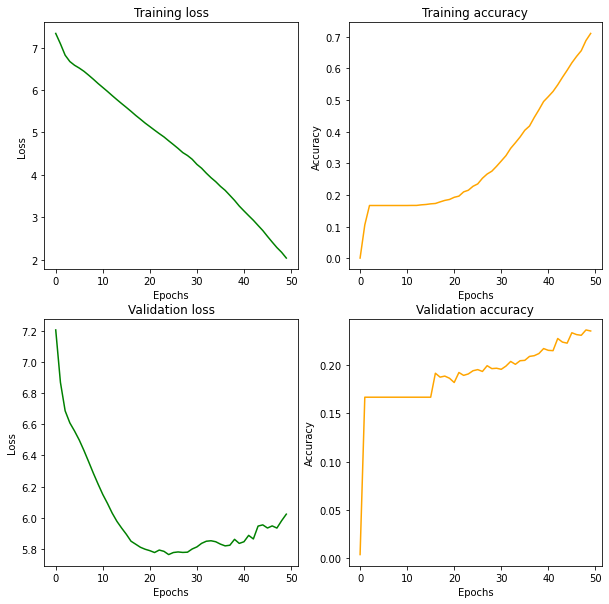

In [35]:
# Đọc các kết quả huấn luyện mô hình qua từng epoch
train_loss, train_acc = history.history['loss'], history.history['masked_accuracy'] # Đọc thông tin loss, acc trên tập train
val_loss, val_acc = history.history['val_loss'], history.history['val_masked_accuracy'] # Đọc thông tin loss, acc trên tập val

plt.figure(figsize=(10, 10)) # Cài đặt kích thước khung ảnh

plt.subplot(2, 2, 1) # Khởi tạo khung ảnh cho training loss
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Loss') # Hiển thị tên trục tung là 'Loss'
plt.title('Training loss') # Hiển thị title của khung ảnh hiện tại là 'Training Loss'
plt.plot(train_loss, color='green') # Vẽ đường giá trị loss trên tập train qua từng epoch (đường vẽ màu đỏ)

plt.subplot(2, 2, 2) # Khởi tạo khung ảnh cho training acc
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Accuracy') # Hiển thị tên trục tung là 'Accuracy'
plt.title('Training accuracy') # Hiển thị title của khung ảnh hiện tại là 'Training accuracy'
plt.plot(train_acc, color='orange') # Vẽ đường giá trị accuracy trên tập train qua từng epoch (đường vẽ màu cam)

plt.subplot(2, 2, 3) # Khởi tạo khung ảnh cho val loss
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Loss') # Hiển thị tên trục tung là 'Loss'
plt.title('Validation loss') # Hiển thị title của khung ảnh hiện tại là 'Validation loss'
plt.plot(val_loss, color='green') # Vẽ đường giá trị loss trên tập val qua từng epoch (đường vẽ màu đỏ)

plt.subplot(2, 2, 4) # Khởi tạo khung ảnh cho val acc
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Accuracy') # Hiển thị tên trục tung là 'Accuracy'
plt.title('Validation accuracy') # Hiển thị title của khung ảnh hiện tại là 'Validation accuracy'
plt.plot(val_acc, color='orange') # Vẽ đường giá trị accuracy trên tập val qua từng epoch (đường vẽ màu cam)

plt.show() # Hiển thị 4 khung ảnh nhỏ

In [36]:
perplexities = []
bleu_scores = []
for sample in val_ds.take(1):
    X_try, y_try = sample
    y_pred = transformer(X_try)
    batch_perplexity = compute_perplexity(y_pred, y_try)
    batch_bleu_score = compute_bleu(y_pred, y_try)

    perplexities.append(batch_perplexity)
    bleu_scores.append(batch_bleu_score)

    # print(f'Perplexity: {batch_perplexity}')
    # print(f'BLEU score: {batch_bleu_score}')

print(f'Perplexity: {sum(perplexities) / len(perplexities)}')
print(f'BLEU score: {sum(bleu_scores) / len(bleu_scores)}')

Perplexity: 1510.8553466796875
BLEU score: 0.28684171547674014


## **7. Inference**

In [37]:
def generate_text(
    generator_model, 
    tokenizer,
    input_string
    ):
    
    encoder_input_string = text_normalize(input_string) 
    encoder_input_sequence = tokenizer.texts_to_sequences([encoder_input_string])
    encoder_input_padded_sequence = pad_sequences(encoder_input_sequence, maxlen=MAX_SEQ_LEN, truncating='pre', padding='post')[0]
    encoder_input_padded_sequence = np.expand_dims(encoder_input_padded_sequence, axis=0)

    decoder_input_string = '<start>'
    decoder_input_sequence = tokenizer.texts_to_sequences([decoder_input_string])
    decoder_input_padded_sequence = pad_sequences(decoder_input_sequence, maxlen=MAX_SEQ_LEN, truncating='pre', padding='post')[0]
    start = decoder_input_padded_sequence[0][tf.newaxis]
    end = decoder_input_padded_sequence[1][tf.newaxis]
    decoder_input_padded_sequence = np.expand_dims(decoder_input_padded_sequence, axis=0)

    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(MAX_SEQ_LEN):
        output = tf.transpose(output_array.stack())
        predictions = generator_model((encoder_input_padded_sequence, output), training=False)

        # Select the last token from the `seq_len` dimension.
        predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

        predicted_id = tf.argmax(predictions, axis=-1)

        # Concatenate the `predicted_id` to the output which is given to the
        # decoder as its input.
        output_array = output_array.write(i+1, predicted_id[0])

        if predicted_id == end:
            break

    output = tf.transpose(output_array.stack())
    output_tokens = output.numpy()
    # The output shape is `(1, tokens)`.
    text = tokenizer.sequences_to_texts(output_tokens)[0]  # Shape: `()`.


    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    generator_model([decoder_input_padded_sequence, output[:, :-1]], training=False)
    attention_weights = generator_model.decoder.last_attn_scores

    return text, output_tokens, attention_weights

In [38]:
n_sentences = 7
results = ['hàng năm mùa nhãn chín']
for idx in range(n_sentences + 1):
    input_str = results[idx]
    text, output_tokens, attention_weights = generate_text(
        transformer, 
        tokenizer,
        input_str
    )
    results.append(text.replace('<start>', '').replace('<end>', ''))

print('\n'.join(results))

hàng năm mùa nhãn chín
 anh rất thơ thuở trước  
 em chỉ cần có anh  
 một bờ về cùng không  
 mang đời dựng về chơi  
 em nào biết được nữa  
 đất trời mưa dài không  
 trời mùa đông rừng núi  
 đời mùa đông vô cùng  
